# Instruction tuning of LLaMA 2

#### What is instruction tuning?

Instruction tuning represents a particular form of fine-tuning where a model is trained on pairs of input-output instructions providing the tuned model the ability to learn specific tasks guided by these instructions.

Providing these input and output pairs trains the model to comprehend and execute tasks based on given instructions. These instructions span a wide array of text types, from composing emails to sentence editing, fostering the model’s adaptability across various instruction-driven tasks. By exposing the model to diverse instructions, it can potentially gain robust generalization skills, enhancing its ability to generate accurate responses aligned with human-like instruction formats.

A good example as a benchmark is the [Stanford Alpaca](https://crfm.stanford.edu/2023/03/13/alpaca.html) model which is a instruction following model trained on an instruction dataset generated in a self-instruct manner. They emphasize that the recipe for this to work well is to have a a strong pretrained language model and high-quality instruction-following data. Their first criterion is satisfied by using Meta's LLaMA 7B model and their second requirement is met by a high quality instruction dataset generated by their self-instruct method.

They started with 175 human-written instruction-output pairs from the self-instruct seed set. These were then used to prompt OpenAI's text-davinci-003 model to generate more instructions using the seed set as in-context examples resulting in 52K unique instructions and the corresponding outputs. Further details on their recipe can be found in their [self-instruct](![alpaca_example.png](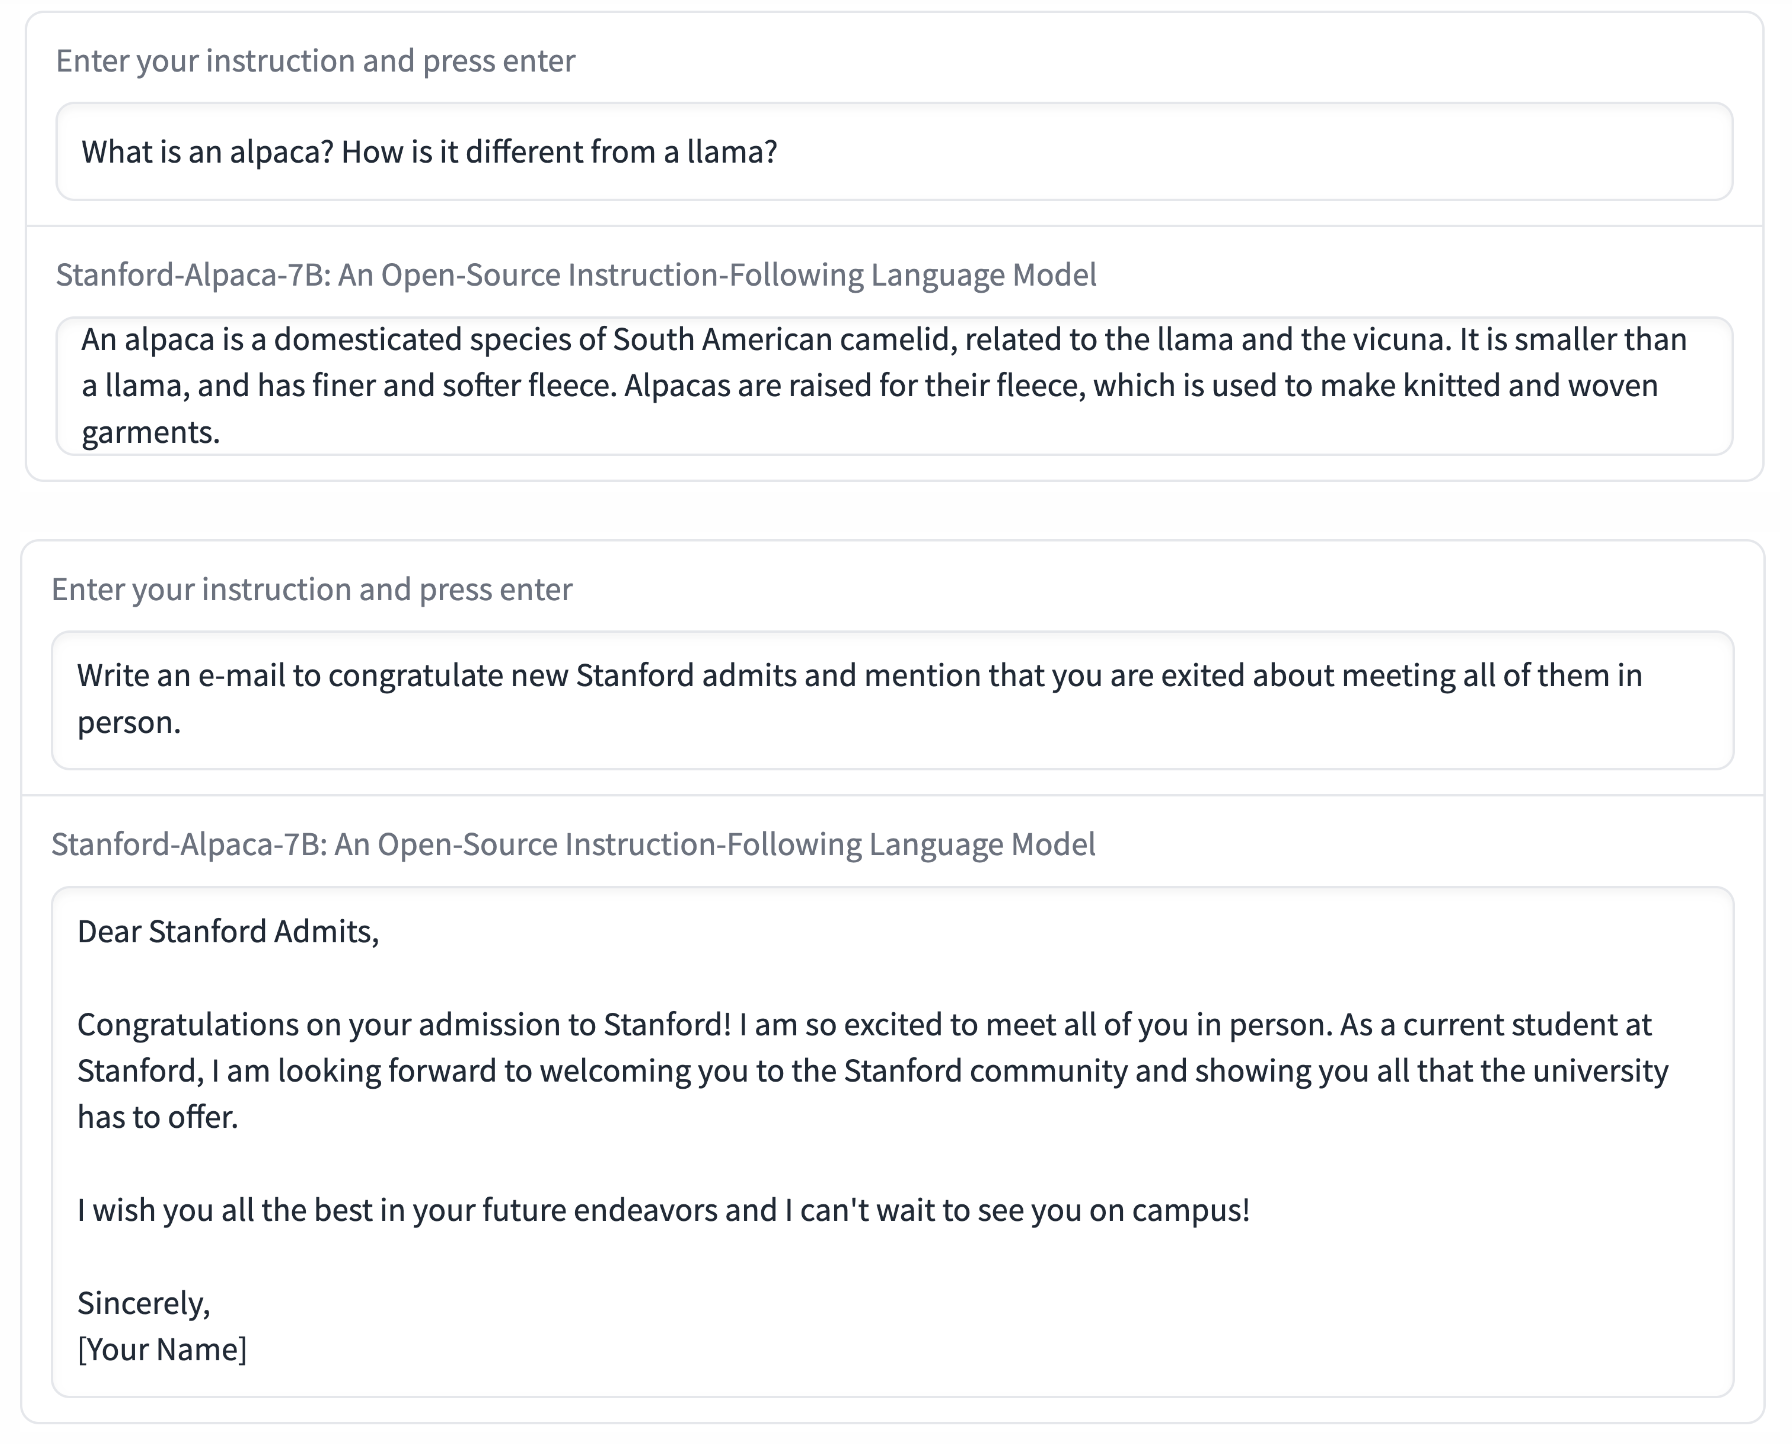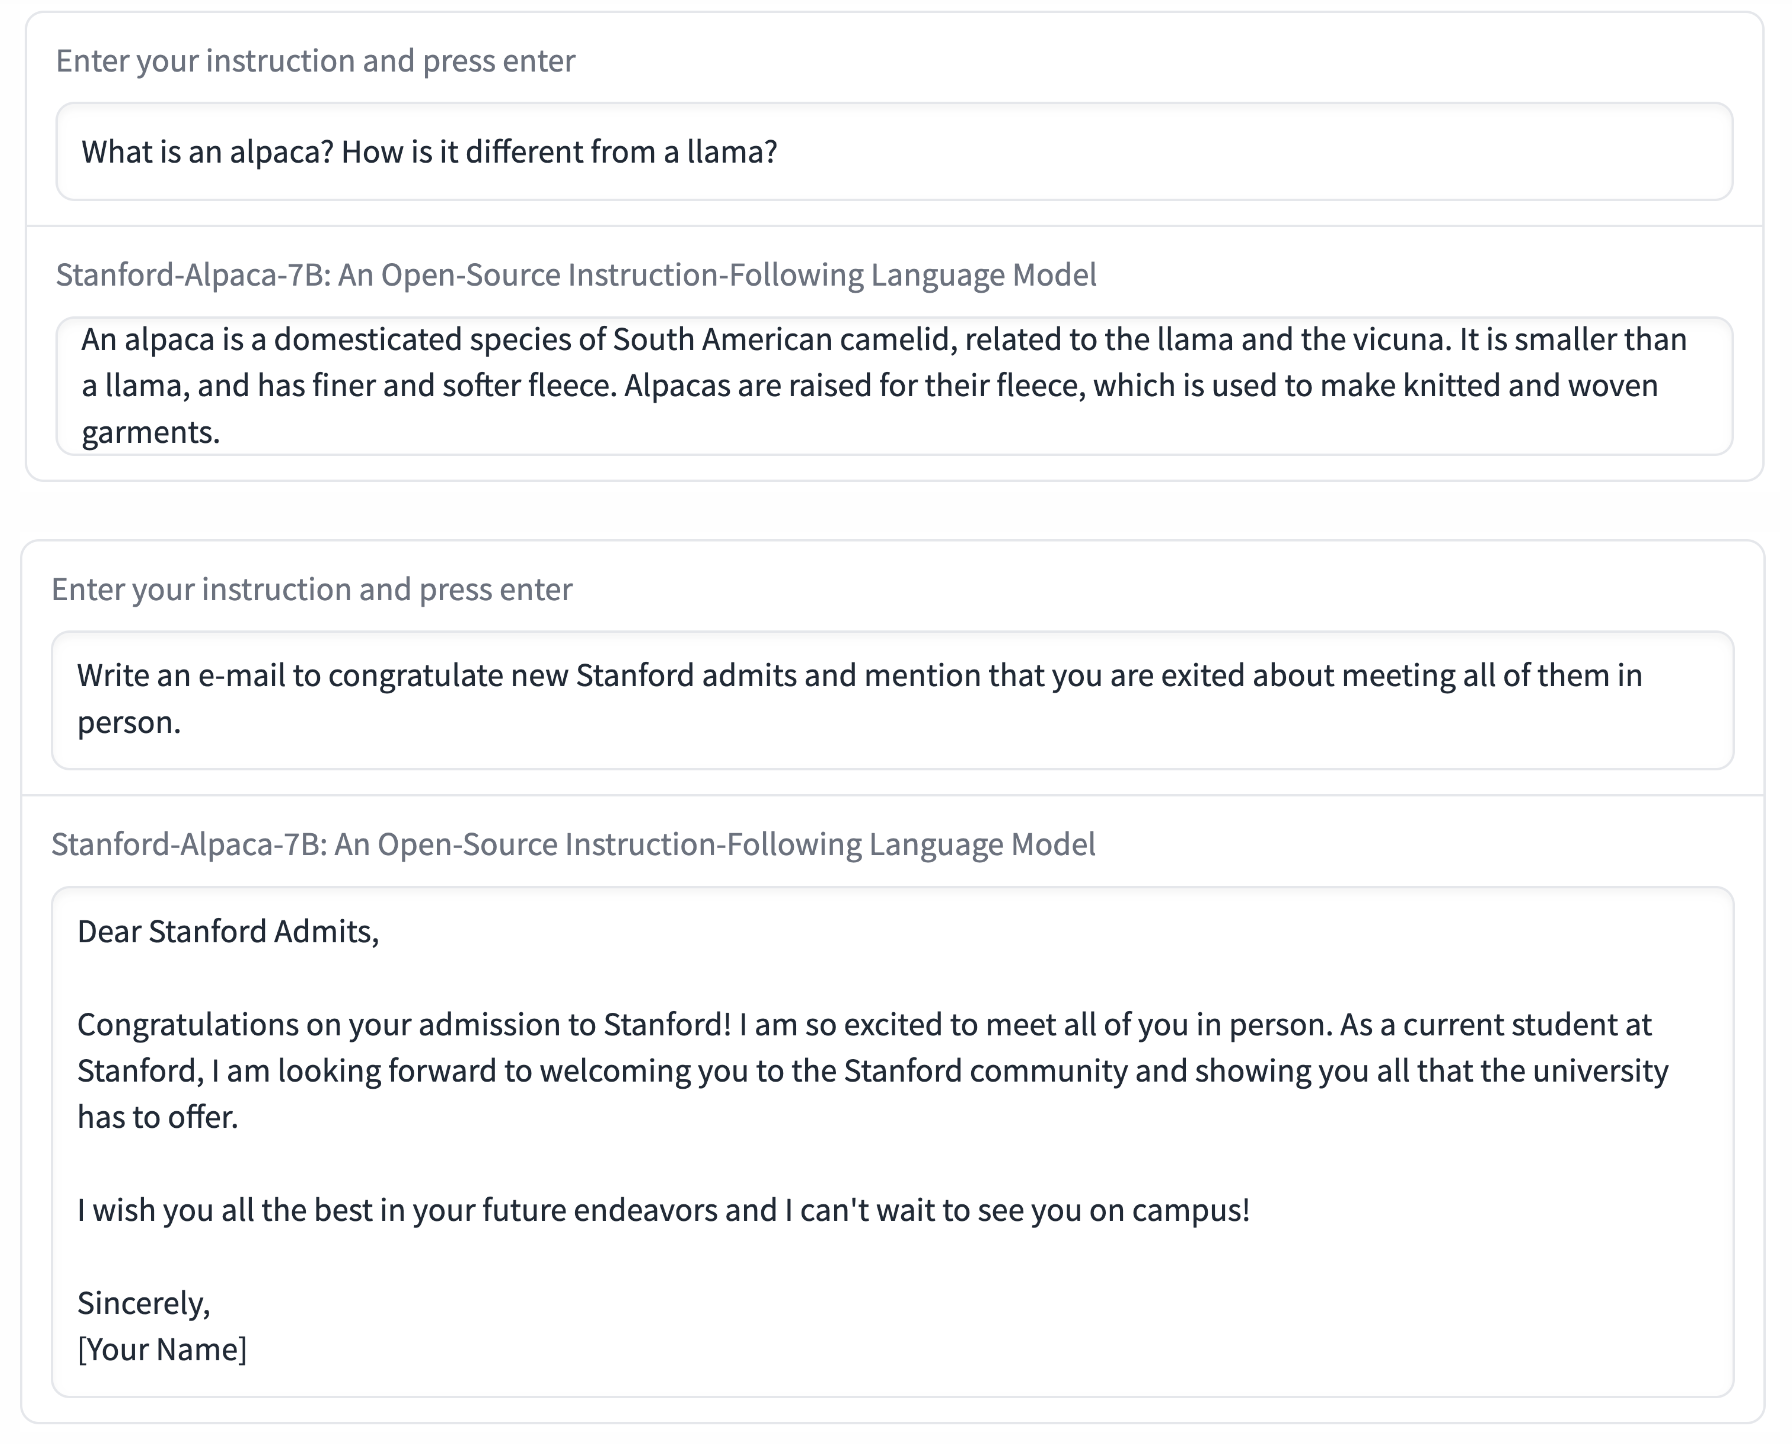)https://arxiv.org/abs/2212.10560://) paper.

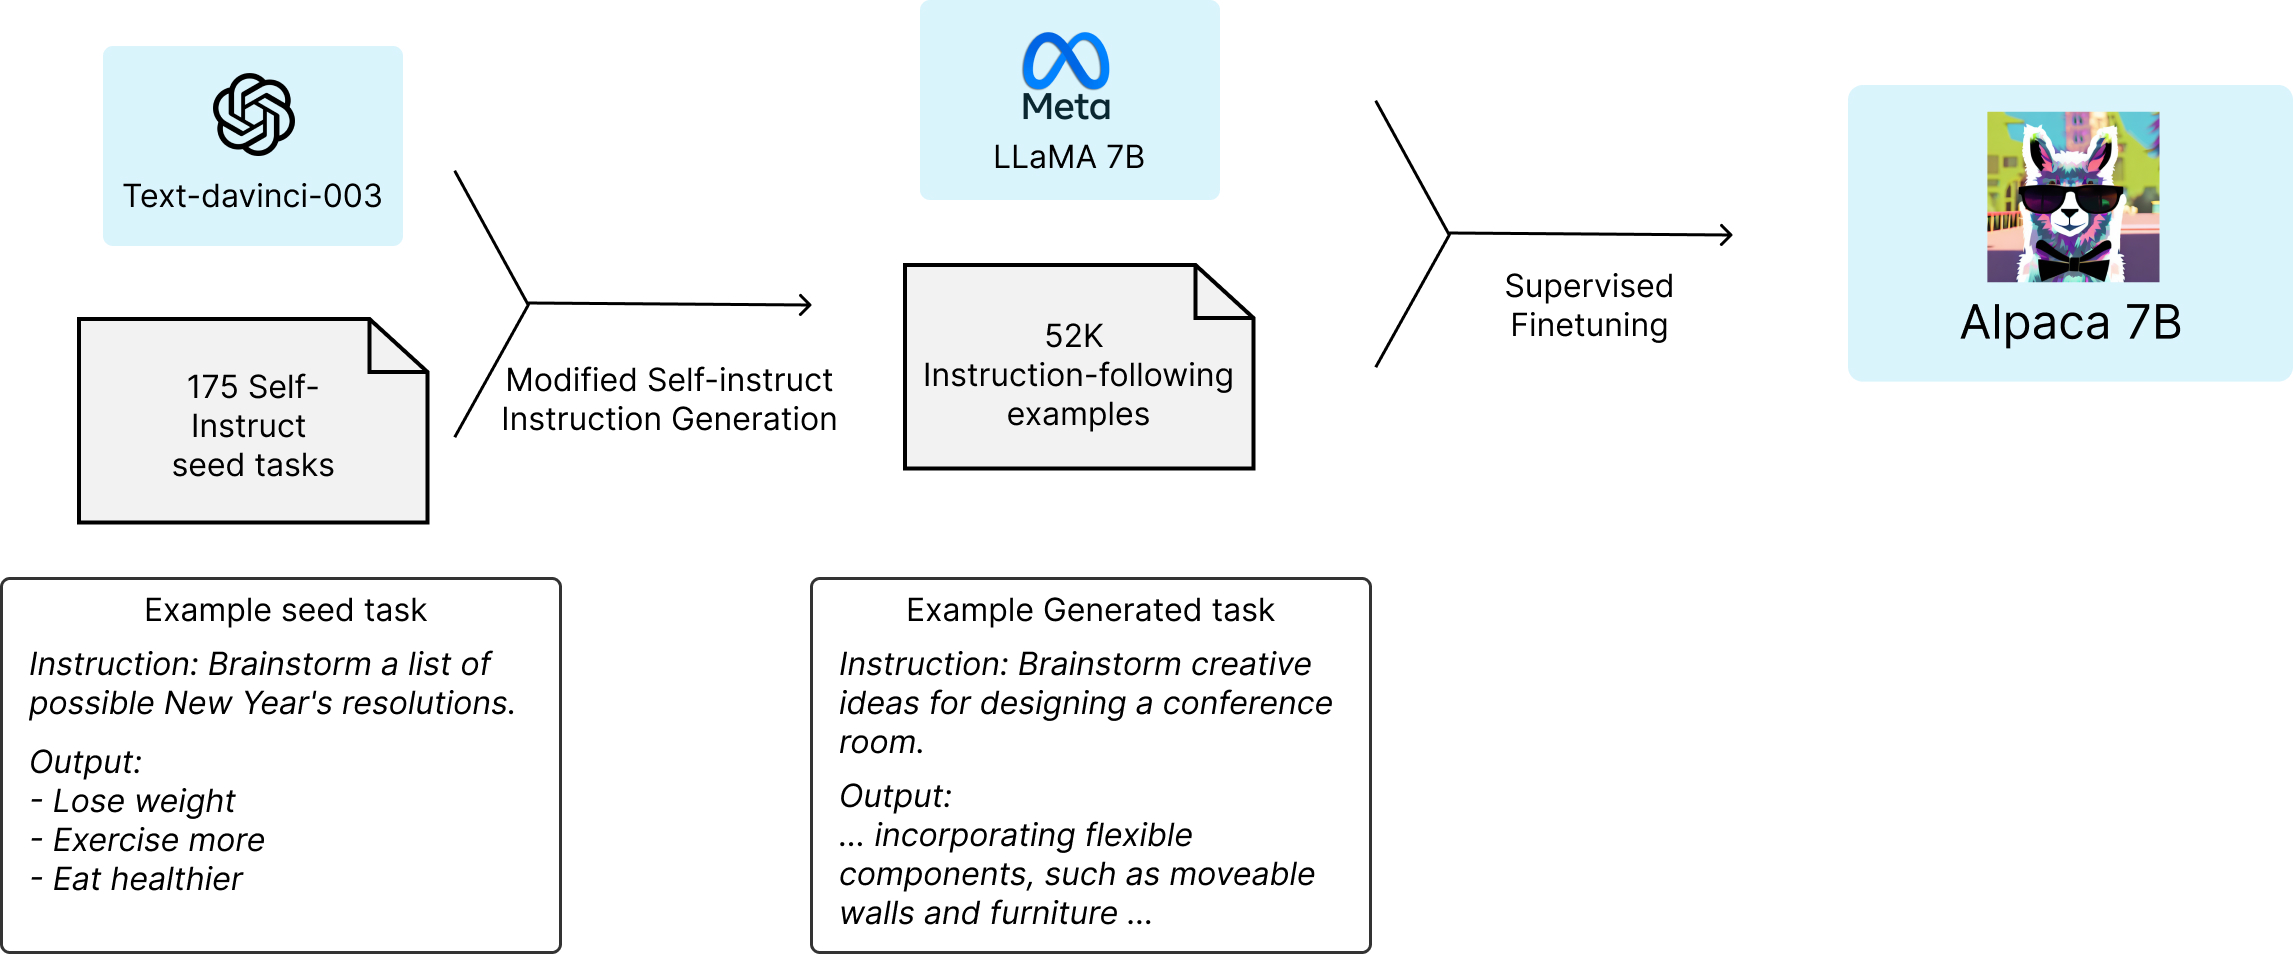




Usual prompt template for a instruction following dataset looks like this -

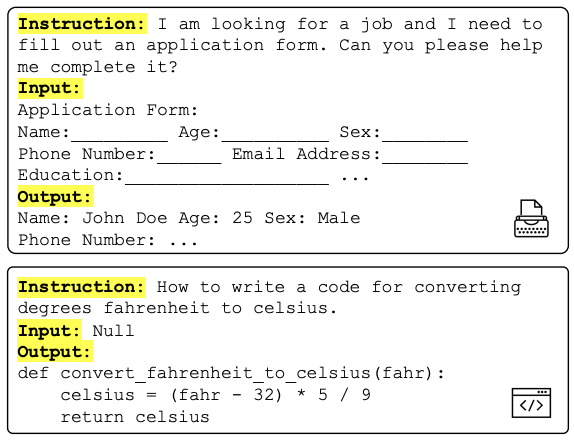

## Parameter-Efficient Fine-tuning (PEFT)

As language models get larger, it becomes impractical to fully fine-tune them on consumer hardware for downstream tasks. Further, since the fully fine-tuned model is the same size as the pretrained model, even storage and depolyment for downstream tasks becomes highly expensive. PEFT approaches are meant to address these challenges. Here is a good article from HF going through the different [PEFT](https://huggingface.co/blog/peft) approaches.

We will go through two popular ones - LoRA and QLoRA.

### What is LoRA?

Low-rank Adaptation (LoRA) essentially works by decomposing the weight changes into a lower rank representation. This [article](https://lightning.ai/pages/community/tutorial/lora-llm/) presents a good summary on the workings of this method. More details can be found in the original paper - [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

While the weights of a pretrained model have full rank on the pretrained tasks, according to [Aghajanyan et al. (2020)](https://arxiv.org/abs/2012.13255) which inspired the work on LoRA, the pretrained large language models have a low “intrinsic dimension” when they are adapted to a new task.

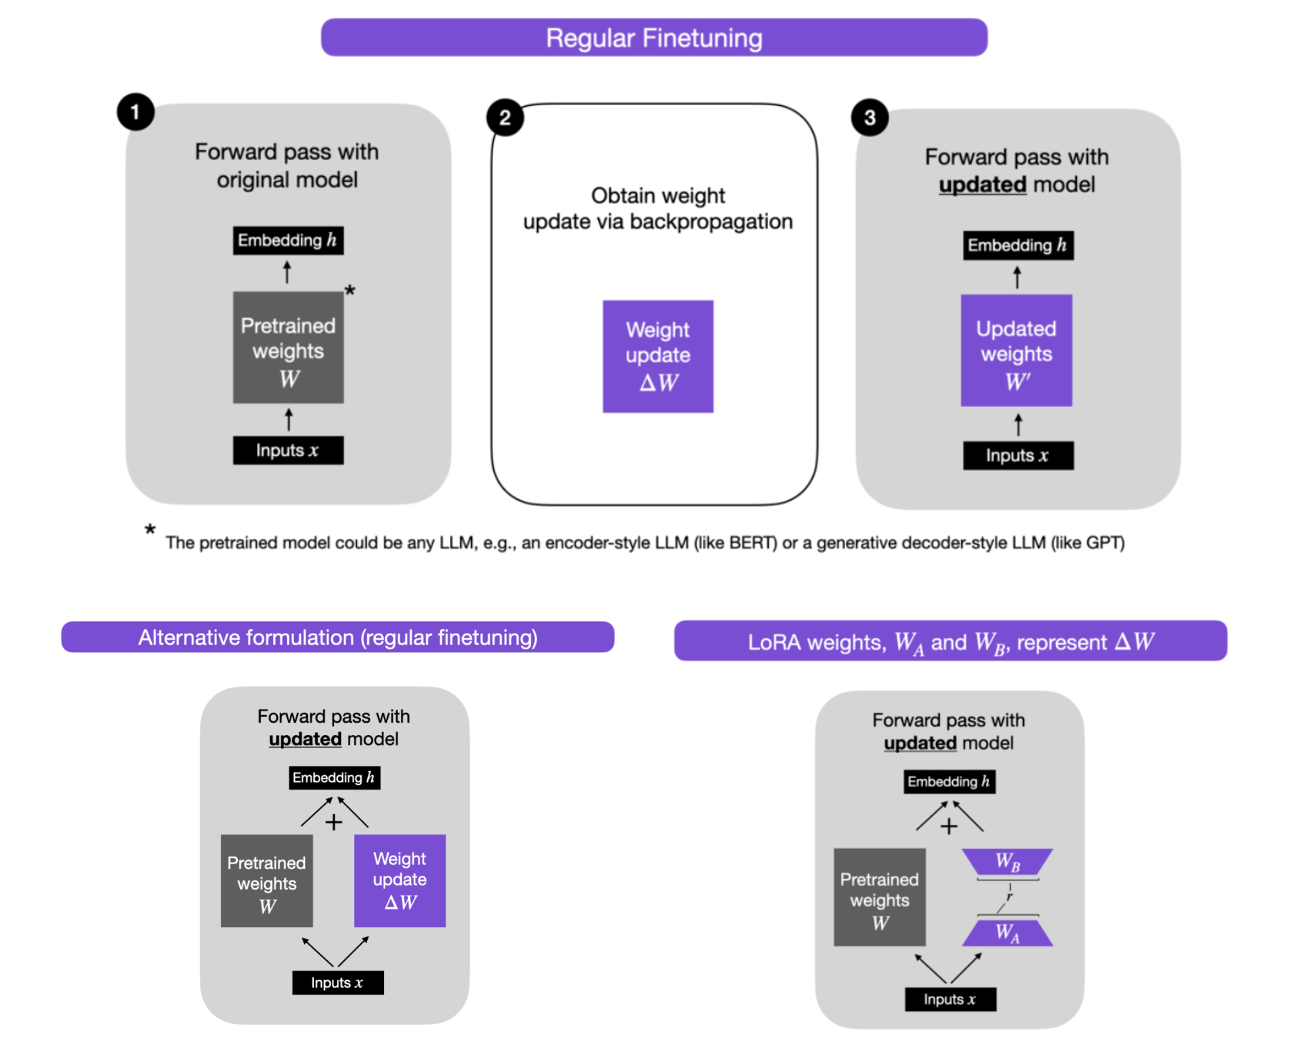

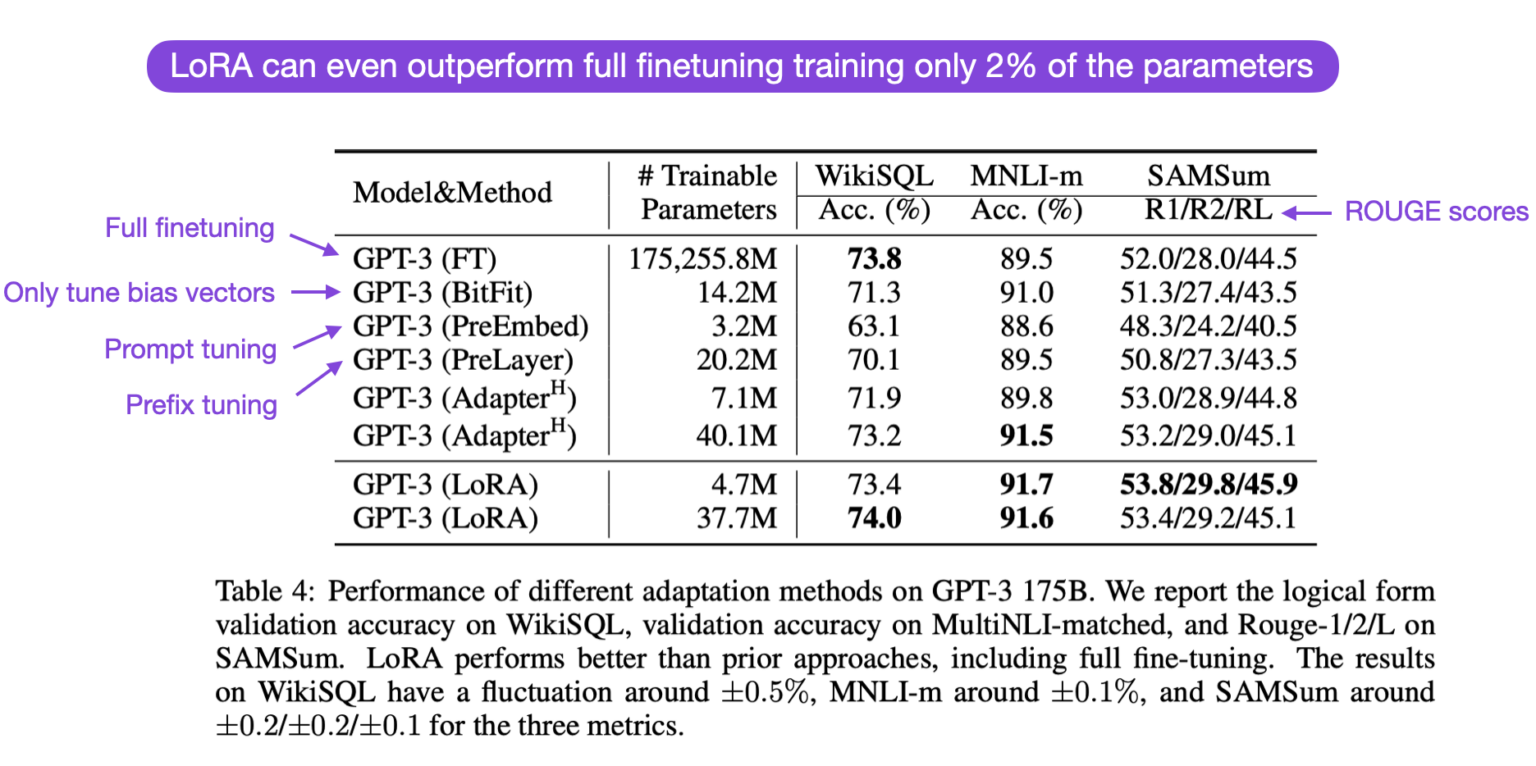

# ΔW = α ( -∇ LW)

### What is QLoRA?


Quantized LoRA (QLoRA) is an extension of LoRA that further introduces quantization to enhance parameter efficiency during fine-tuning. I point to this [article](https://www.analyticsvidhya.com/blog/2023/08/lora-and-qlora/) for an introductory summary. There is also this [talk](https://www.youtube.com/watch?v=y9PHWGOa8HA) by one of the authors of the original paper - [QLORA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2106.09685).

The method introduces 4-bit NormalFloat (NF4) quantization and Double Quantization techniques applied to LoRA.

* NF4 Quantization: NF4 quantization leverages the inherent distribution of pre-trained neural network weights, usually zero-centered normal distributions with specific standard deviations. By transforming all weights to a fixed distribution that fits within the range of NF4 (-1 to 1), NF4 quantization effectively quantifies the weights without the need for expensive quantile estimation algorithms.

* Double Quantization: Double Quantization addresses the memory overhead of quantization constants. Double Quantization significantly reduces the memory footprint without compromising performance by quantizing the quantization constants themselves. The process involves using 8-bit Floats with a block size 256 for the second quantization step, resulting in substantial memory savings.

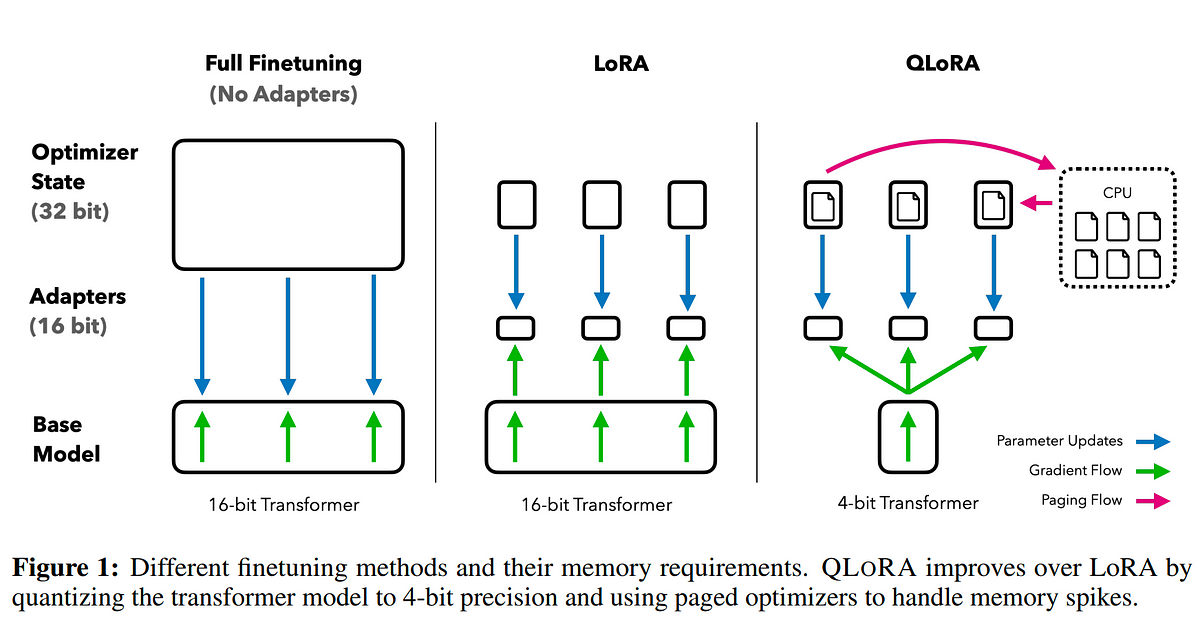

## Instruct tuning in PEFT mode

The training setup in this notebook follows [maximelabonne's](https://mlabonne.github.io/blog/posts/Fine_Tune_Your_Own_Llama_2_Model_in_a_Colab_Notebook.html) notebook fine-tuning Llama2 model using instruction dataset

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework

In [ ]:
# Imports
import os
import torch
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers import HfArgumentParser, TrainingArguments
from transformers import pipeline, logging

In [ ]:
# Performance
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# Base Llama2 model to be loaded
model_name = "NousResearch/Llama-2-7b-chat-hf"

# Instruction dataset to be used for fine-tuning the base model
dataset_name = "mlabonne/guanaco-llama2-1k"

# Name of model to be pushed to hub post fine-tuning
tuned_model = "llama-2-7b-guanaco-1k"

In [ ]:
# Parameters for quantized training via bitsandbytes

# 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [ ]:
# QLoRA - quantized LoRA training parameters

# LoRA rank
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

In [ ]:
# Training arguments

# Output directory to store results
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

In [ ]:
# Supervised fine-tuning (SFT) parameters

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [10]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset(dataset_name, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Load tokenizer and model with QLoRA configuration

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [ ]:
# # Check GPU compatibility with bfloat16

# if compute_dtype == torch.float16 and use_4bit:
#     major, _ = torch.cuda.get_device_capability()
#     if major >= 8:
#         print("=" * 80)
#         print("Your GPU supports bfloat16: accelerate training with bf16=True")
#         print("=" * 80)

In [ ]:
# Load base model

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

In [ ]:
# Load LLaMA tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
# Load LoRA configuration

peft_config = LoraConfig(
                  lora_alpha=lora_alpha,
                  lora_dropout=lora_dropout,
                  r=lora_r,
                  bias="none",
                  task_type="CAUSAL_LM",
              )

In [ ]:
# Set training arguments

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
# Set supervised fine-tuning parameters

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.408500
50,1.659800
75,1.214000
100,1.439000
125,1.177000
150,1.361500
175,1.173000
200,1.459700
225,1.157300
250,1.533200


TrainOutput(global_step=250, training_loss=1.3583098602294923, metrics={'train_runtime': 1505.6741, 'train_samples_per_second': 0.664, 'train_steps_per_second': 0.166, 'total_flos': 8755214190673920.0, 'train_loss': 1.3583098602294923, 'epoch': 1.0})

In [ ]:
# Saving trained model
trainer.model.save_pretrained(tuned_model)

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

### Text generation using the fine-tuned model

In [ ]:
# Set text generation pipeline
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

In [ ]:
def generate(prompt="", pipe=pipe):
    """ Generate with given prompt """

    result = pipe(f"<s>[INST] {prompt} [/INST]")
    return result[0]['generated_text']

In [ ]:
# Run text generation pipeline with instruct-tuned model
prompt = "What is a large language model?"
generated_text = generate(prompt=prompt)
print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will

<s>[INST] What is a large language model? [/INST] A large language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text to generate human-like language outputs. These models are typically trained on vast amounts of text data, such as books, articles, and websites, and are designed to learn the patterns and structures of language.

Large language models are often used for natural language processing tasks such as text classification, sentiment analysis, and machine translation. They are also used for more creative tasks such as writing poetry, stories, and even entire books.

Some examples of large language models include:

* BERT (Bidirectional Encoder Representations from Transformers): A popular language model developed by Google that is trained on a large dataset of text and is known for its ability to generate human-like language outputs.
* LLaMA (LLaMA): A large language model developed


In [ ]:
prompt = "Explain to me pythagoras theorem"
generated_text = generate(prompt=prompt)
print(generated_text)

<s>[INST] Explain to me pythagoras theorem [/INST] Pythagoras theorem is a mathematical formula that describes the relationship between the lengths of the sides of a right triangle. It states that the square of the hypotenuse (the side opposite the right angle) is equal to the sum of the squares of the other two sides.

In mathematical notation, this formula can be written as:

a^2 + b^2 = c^2

Where a and b are the lengths of the two shorter sides of the triangle, and c is the length of the hypotenuse.

For example, if you have a right triangle with sides measuring 3, 4, and 5, you can use the Pythagoras theorem to find the length of the hypotenuse:

3^2 + 4^2 = 5^2

Solving for the length of the hyp


In [ ]:
prompt = "What is grand unified theory?"
generated_text = generate(prompt=prompt)
print(generated_text)

<s>[INST] What is grand unified theory? [/INST] Grand Unified Theory (GUT) is a theoretical framework in physics that attempts to unify three of the four fundamental forces of nature: electromagnetism, the strong nuclear force, and the weak nuclear force. The fourth force, gravity, is not yet included in the GUT.

The GUT is based on the idea that all of these forces are manifestations of a single underlying field, known as the unified field. This field is thought to be a scalar field that permeates all of space and time, and it is the source of all of the fundamental forces.

The GUT is a very ambitious and complex theory, and it has been the subject of much research and debate in the physics community. While it has not yet been experimentally confirmed, it is one of the most promising approaches to understanding the fundamental nature of the universe.

One of the key


In [ ]:
prompt = "List Maxwell's equations of electromagnetism"
generated_text = generate(prompt=prompt)
print(generated_text)

<s>[INST] List Maxwell's equations of electromagnetism [/INST] Maxwell's equations of electromagnetism are a set of four partial differential equations that describe the behavior of electric and magnetic fields in space and time. These equations are:

1. Gauss's law for electric fields: ∇⋅E = ρ/ε0
2. Gauss's law for magnetic fields: ∇⋅B = 0
3. Faraday's law of induction: ∇×E = -∂B/∂t
4. Ampere's law with Maxwell's correction: ∇×B = μ0J + μ0ε0∂E/∂t

These equations are known as Maxwell's equations, and they provide a complete and consistent description of the behavior of electric and magnetic fields in a wide range of physical situations, from the simplest electrical circuits to


In [ ]:
prompt = "What are the system pathways playing a crucial role in lung cancer?"
generated_text = generate(prompt=prompt)
print(generated_text)

<s>[INST] What are the system pathways playing a crucial role in lung cancer? [/INST] The system pathways playing a crucial role in lung cancer are:

1. Epidermal Growth Factor Receptor (EGFR) signaling pathway: This pathway is involved in cellular proliferation, migration, and survival. Mutations in the EGFR gene are common in non-small cell lung cancer (NSCLC) and are associated with increased proliferation and poor prognosis.
2. PI3K/Akt signaling pathway: This pathway is involved in cellular survival and proliferation. Mutations in the PI3K gene are common in NSCLC and are associated with increased proliferation and poor prognosis.
3. MAPK signaling pathway: This pathway is involved in cellular proliferation,


In [ ]:
prompt = "What is the difference between NP hard and NP complete?"
generated_text = generate(prompt=prompt)
print(generated_text)

<s>[INST] What is the difference between NP hard and NP complete? [/INST] NP-hard and NP-complete are related concepts in computational complexity theory.

NP-hard refers to a problem that is hard to solve in NP, meaning that it is computationally infeasible to solve it in polynomial time. In other words, if a problem is NP-hard, it means that there is no known algorithm that can solve it in polynomial time.

NP-complete, on the other hand, refers to a problem that is both NP-hard and has a known polynomial-time algorithm. In other words, if a problem is NP-complete, it means that there is a known algorithm that can solve it in polynomial time, but it is also computationally infeasible to solve it in polynomial time.

To illustrate the difference between NP-hard and NP-complete, consider the following example


## An example of a simple scientific instruction dataset that you can play with!

#### [SciBench](https://github.com/mandyyyyii/scibench) is a novel benchmark for college-level scientific problems consisting of 695 problems sourced from instructional textbooks. The benchmark is designed to evaluate the complex reasoning capabilities, strong domain knowledge, and advanced calculation skills of LLMs.

Below is the code provided from [Platypus](https://github.com/arielnlee/Platypus/blob/main/data_pipeline/scibench_format.py) repo that has scripts for formatting data in instruct form

In [1]:
# https://github.com/arielnlee/Platypus/blob/main/data_pipeline/scibench_format.py

import os
import json
import subprocess
import os
# The directory where the json files are stored
# dir_path = 'original'
output_file = 'scibench_formatted.json'

import subprocess


# Define the repository URL
repo_url = "https://github.com/mandyyyyii/scibench.git"
repo_name = "scibench"
target_subdir = "dataset/original"

# Clone the repository
result_clone = subprocess.run(["git", "clone", repo_url])

# Check if the clone command was successful
if result_clone.returncode == 0:
    print("Repository cloned successfully!")

    # Construct the path to the target directory within the cloned repository
    target_path = os.path.join(os.getcwd(), repo_name, target_subdir)
    print("Path to the target directory:", target_path)
else:
    print("An error occurred while cloning the repository.")

json_files = [f for f in os.listdir(target_path) if f.endswith('.json')]


new_data = []

# Iterate over all the files
for json_file in json_files:
    file_path = os.path.join(target_path, json_file)

    # Open each json file
    with open(file_path, 'r') as f:
        # Load the data
        file_data = json.load(f)

        # Transform the data
        for d in file_data:
            output = d.get('solution')
            if not output:
                output = d.get('answer_number')
            transformed_data = {
                "instruction": d.get('problem_text'),
                "input": '',
                "output": output
            }
            new_data.append(transformed_data)

# Save the transformed data to a new json file
with open(output_file, 'w') as f:
    json.dump(new_data, f, indent=1)

# Remove the cloned repository
result_remove = subprocess.run(["rm", "-rf", repo_name])

Repository cloned successfully!
Path to the target directory: /content/scibench/dataset/original


In [14]:
new_data[:2]

[{'instruction': 'In this problem, 3.00 mol of liquid mercury is transformed from an initial state characterized by $T_i=300 . \\mathrm{K}$ and $P_i=1.00$ bar to a final state characterized by $T_f=600 . \\mathrm{K}$ and $P_f=3.00$ bar.\r\na. Calculate $\\Delta S$ for this process; $\\beta=1.81 \\times 10^{-4} \\mathrm{~K}^{-1}, \\rho=13.54 \\mathrm{~g} \\mathrm{~cm}^{-3}$, and $C_{P, m}$ for $\\mathrm{Hg}(l)=27.98 \\mathrm{~J} \\mathrm{~mol}^{-1} \\mathrm{~K}^{-1}$.',
  'input': '',
  'output': 'a. Because the volume changes only slightly with temperature and pressure over the range indicated,\r\n$$\r\n\\begin{aligned}\r\n& \\Delta S=\\int_{T_i}^{T_f} \\frac{C_P}{T} d T-\\int_{P_i}^{P_f} V \\beta d P \\approx n C_{P, m} \\ln \\frac{T_f}{T_i}-n V_{m, i} \\beta\\left(P_f-P_i\\right) \\\\\r\n& =3.00 \\mathrm{~mol} \\times 27.98 \\mathrm{~J} \\mathrm{~mol}^{-1} \\mathrm{~K}^{-1} \\times \\ln \\frac{600 . \\mathrm{K}}{300 . \\mathrm{K}} \\\\\r\n& -3.00 \\mathrm{~mol} \\times \\frac{200.59 